<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200409_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc2
2.1.0


# Import data

In [3]:
(ds_train, ds_dev, ds_test), info = tfds.load('cats_vs_dogs', split=('train[:80%]', 'train[80%:90%]', 'train[90%:]')
    # , shuffle_files=True
    , with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [0]:
INPUT_SHAPE = info.features['image'].shape
LABEL_NAMES = info.features['label'].names
N_LABELS = info.features['label'].num_classes

In [5]:
if INPUT_SHAPE[0:2]==(None, None):
    INPUT_SHAPE = (224, 224, 3)
    print("Input Shape is changed to {}".format(INPUT_SHAPE))

Input Shape is changed to (224, 224, 3)


Label: 1 - dog Image Max Value: 255, with size: (262, 350, 3)


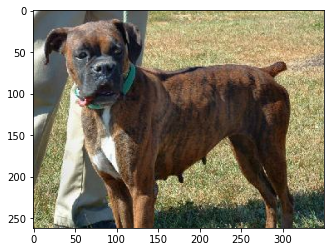

In [6]:
# check data structure
for img, label in ds_train.take(1):
    image = img.numpy().squeeze()
    label = label.numpy()

    print("Label: {} - {}".format(label, LABEL_NAMES[label]), "Image Max Value: {}, with size: {}".format(image.max(), image.shape))
    # plt.imshow(image, cmap=plt.cm.binary)
    plt.imshow(image)
    plt.show()

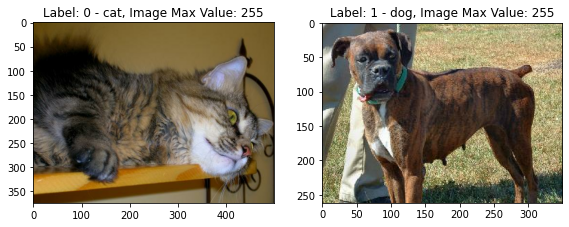

In [7]:
fig = plt.figure(figsize=(25, np.ceil(N_LABELS/5)*5))

for i in range(N_LABELS):
    ds_temp_train = ds_train.filter(lambda img, label: label==i)
    for img, label in ds_temp_train.take(1):
        image = img.numpy().squeeze()
        label = label.numpy()

        fig.add_subplot(np.ceil(N_LABELS/5), 5, i+1)
        # plt.imshow(image, cmap=plt.cm.binary)
        plt.imshow(image)
        plt.title("Label: {} - {}, Image Max Value: {}".format(label, LABEL_NAMES[label], image.max()))

# Pre-processing

In [0]:
def preprocessor(imgs, labels):
    imgs = tf.image.resize(imgs, INPUT_SHAPE[0:2])    
    return imgs, labels

In [0]:
# ds_train = ds_train.map(preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(n_train).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
# ds_dev = ds_dev.map(preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

ds_train = ds_train.map(preprocessor).shuffle(n_train).batch(128)
ds_dev = ds_dev.map(preprocessor).batch(128)
ds_test = ds_test.map(preprocessor)

In [10]:
print(next(iter(ds_test.batch(10).take(1)))[1].numpy())
print(next(iter(ds_test.batch(10).take(1)))[1].numpy())
print(next(iter(ds_test.batch(10).take(1)))[1].numpy())

[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]
[0 1 1 0 0 0 1 0 0 0]


# Modeling

In [0]:
def model_preprocessor(imgs):
    imgs = tf.cast(imgs, tf.float32)
    imgs /= 255.0
    return imgs    

In [0]:
def getModel():
    from tensorflow.keras import Sequential
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Dropout, GlobalAveragePooling2D
    from tensorflow.keras.optimizers import Adam    

    base_model = VGG16(weights='imagenet', include_top=False
                       , input_shape=(224, 224, 3)
                       , classes=N_LABELS)
    for layer in base_model.layers:
        layer.trainable = False
    # print(base_model.summary())
    model = Sequential()
    model.add(Input(shape=INPUT_SHAPE))
    model.add(Lambda(model_preprocessor))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))    
    model.add(Dense(2, activation='softmax'))    

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
cb_earlystop = EarlyStopping(patience=10)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(ds_train, epochs=5, validation_data=ds_dev, verbose=1
                    # , callbacks=[cb_tensorboard]
                    # , callbacks=[cb_earlystop, cb_learning_rate_reduction]
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

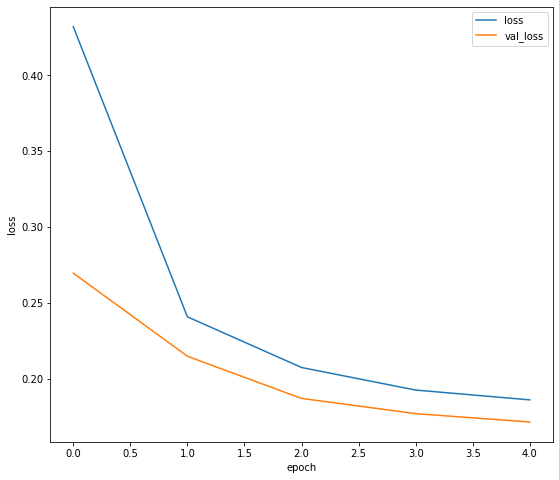

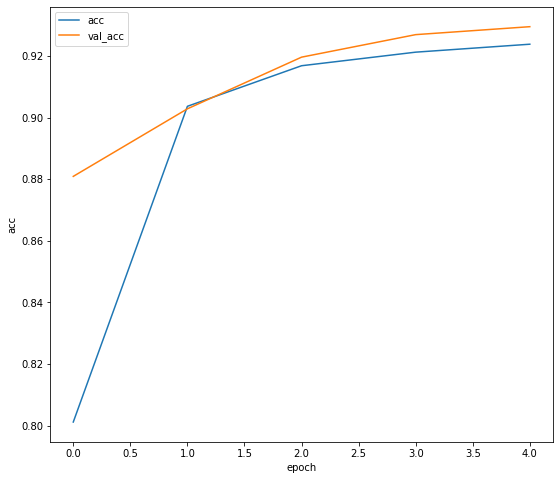

In [14]:
def plot_history(history):
    hist = history.history
    for key in ['loss', 'acc']:
        plt.figure(figsize=(9, 8))
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

# Model Evaluation

In [17]:
eval = model.evaluate(ds_test.batch(128))
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

19/19 [==============================] - 20s 1s/step - loss: 0.1643 - acc: 0.9299
Test data: Loss = 0.16431769728660583, Accuracy = 0.9299226403236389
Right Prediction: 2163.000061392784, Wrong Prediction: 162.99993860721588


In [20]:
%%time

test_labels = np.array(next(iter(ds_test.batch(n_test).take(1)))[1])
test_pred = model.predict(ds_test.batch(128)).argmax(axis=1)

CPU times: user 19.3 s, sys: 2.32 s, total: 21.6 s
Wall time: 26.2 s


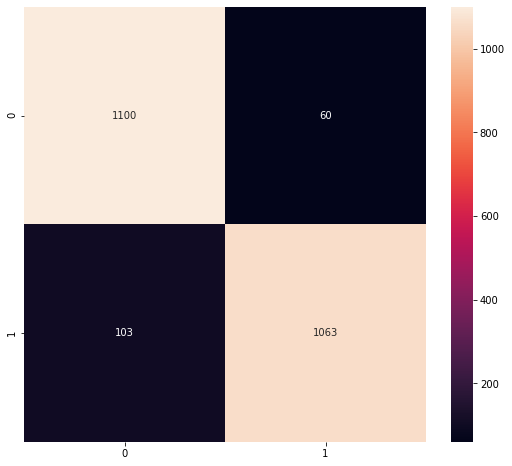

In [21]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(N_LABELS), range(N_LABELS)), annot=True, fmt='d')

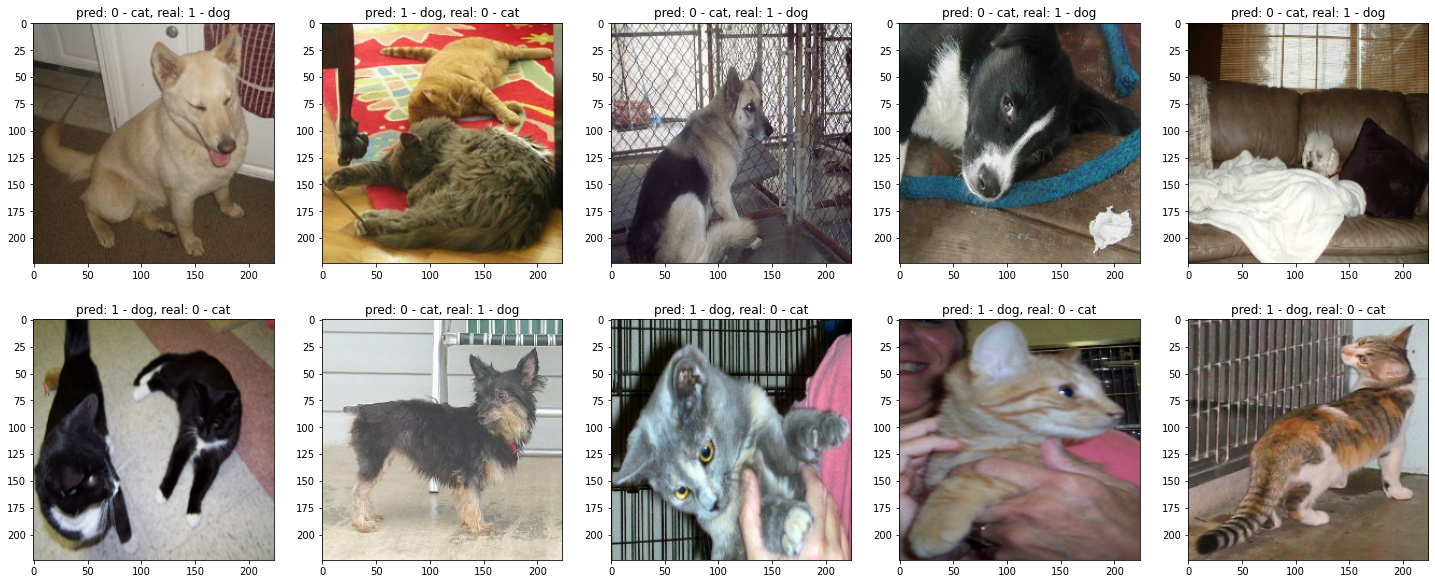

In [31]:
nrows, ncols = 2, 5

iimgs = np.where(test_labels!=test_pred)[0]
fig = plt.figure(figsize=(5*ncols,5*nrows))
for i in range(10):
    iimg = iimgs[i]
    for img, label in ds_test.skip(iimg).take(1):
        fig.add_subplot(2, 5, i+1)
        plt.imshow(img.numpy().squeeze())
        plt.title('pred: {} - {}, real: {} - {}'.format(test_pred[iimg], LABEL_NAMES[test_pred[iimg]], test_labels[iimg], LABEL_NAMES[test_labels[iimg]]))